# Automatic Fringe tracing
by Jakub Dranczewski, UROP 2018

In [1]:
# Uncomment if you don't have magpie_tools/code in your PYTHONPATH
# import sys
# sys.path.append("C:\\Users\\User\\Documents\\magpie_tools\\code")

In [2]:
import fringe_tracing_smoothing as ft
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [3]:
# Run twice to ensure interactivity
%matplotlib notebook

## Open an interferogram
First, specify a working folder. Then, give a name of the file containing a photo of the fringes.

In [4]:
%cd "C:\Users\User\Documents\pendrive\Sample interferograms"
interferogram, fn = ft.load_file('s0609_15 532nm end on interferometry t215ns.JPG')

C:\Users\User\Documents\pendrive\Sample interferograms


## Normalising the interferogram
Select a blur at which the left picture doesn't have visible fringes. Then select a clip that brings out the contrast well on the right picture.

In [5]:
blur = 15
blurred_interferogram = ft.blur(interferogram, blur)
normalised_interferogram = interferogram/blurred_interferogram

<IPython.core.display.Javascript object>


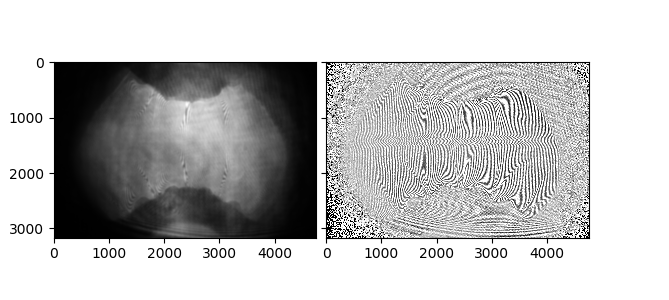

(<matplotlib.image.AxesImage at 0x23e01616d68>,
 <matplotlib.image.AxesImage at 0x23e01628080>)

In [6]:
clip=[0.3,1.2]
clipped_interferogram = (np.clip(normalised_interferogram, a_min=clip[0], a_max=clip[1])-clip[0])/(clip[1]-clip[0])
fig = plt.figure(figsize=(6.69,3))
ft.plot_compare(fig, blurred_interferogram, clipped_interferogram)

The file will be saved with the same file name as the one you have opened before, but with `normalised` appended at the end. You can use this file while tracing in Photoshop, it should be clearer than the photo you have started with

In [7]:
ft.save_file(fn+' normalised', clipped_interferogram)

## Thresholding the interferogram
The interferogram will now be converted to a binary image. The window size parameter is used by the thresholding function - the contrast in the given window is used to determine the threshold. `k` is a weighing variable, you can read more about it [here](http://scikit-image.org/docs/dev/api/skimage.filters.html#threshold-niblack).

You can try changing both if the results are not satisfactory.

In [8]:
window_size = 51
k = 0.3
thresholded = ft.threshold(clipped_interferogram, window_size, k)

<IPython.core.display.Javascript object>


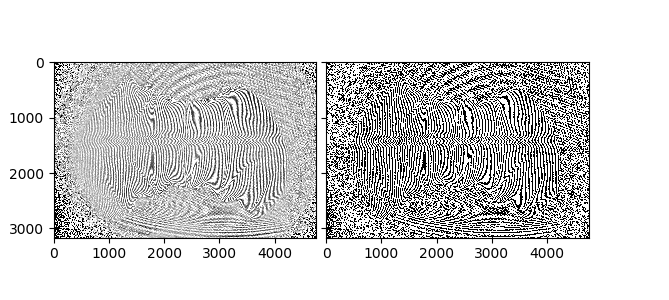

(<matplotlib.image.AxesImage at 0x23e025b4be0>,
 <matplotlib.image.AxesImage at 0x23e025b4e80>)

In [9]:
fig = plt.figure(figsize=(6.69,3))
ft.plot_compare(fig, clipped_interferogram, thresholded)

## Finding and smoothing the contours
The contours are first found, and then averaged. You can adjust the range used to average with the `range_len=10` argument. Short contours are rejected, you can change the threshold for that by altering the `limit_len` argument's value.

In [10]:
contours = ft.contours(thresholded)

In [11]:
smoothed_contours = ft.smooth_contours(contours, range_len=10, limit_len=500)

FloatProgress(value=0.0, max=74623.0)

## Painting in the contours
Once the contours are smoothed, we need to paint their insides.

In [12]:
painted_in = ft.paint_in(smoothed_contours, interferogram)

FloatProgress(value=0.0, max=750.0)

<IPython.core.display.Javascript object>


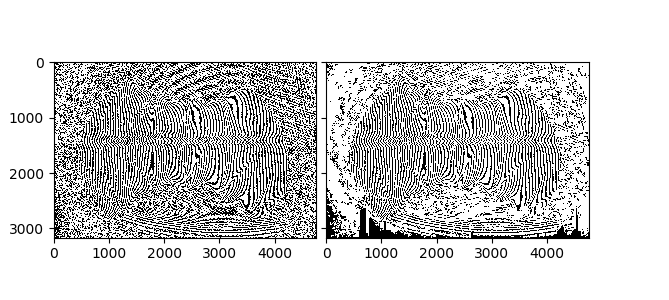

(<matplotlib.image.AxesImage at 0x23e035112e8>,
 <matplotlib.image.AxesImage at 0x23e03511588>)

In [13]:
fig = plt.figure(figsize=(6.69,3))
ft.plot_compare(fig, thresholded, painted_in)

## Thinning the fringes
The fringes will now be reduced to pixel-wide lines.

You can set `do_bright` and `do_dark` to true or false, depending on which fringes you want to have traced.

In [14]:
do_bright = True
do_dark = True

thinned = np.zeros_like(interferogram)
if do_bright:
    thinned_bright = ft.thin_fringes(painted_in)
    thinned = np.logical_or(thinned, thinned_bright)
if do_dark:
    thinned_dark = ft.thin_fringes(painted_in, inverse=True)
    thinned = np.logical_or(thinned, thinned_dark)

Thinning bright fringes...
Thinning dark fringes...


<IPython.core.display.Javascript object>


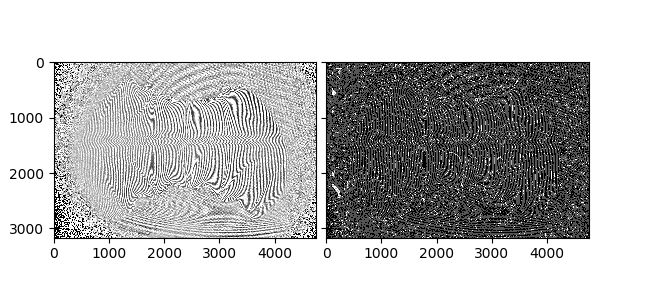

(<matplotlib.image.AxesImage at 0x23e0354dc50>,
 <matplotlib.image.AxesImage at 0x23e0354def0>)

In [15]:
fig = plt.figure(figsize=(6.69,3))
ft.plot_compare(fig, clipped_interferogram, thresholded*1 + thinned*2)

## Saving the picture
This saves the traced fringes. They will be black on a transparent background, so you can easily use the image as a layer in Photoshop.

In [16]:
ft.save_file_alpha(fn+' traced', thinned, invert=True)

## The possible errors mask
Running the cells below will create a .png with red pixels indicating potentially problematic areas. This should be helpful while manually cleaning up the interferogam.

You can import the image as a layer in Photoshop and control its transparency so that you still see the fringes below it.

The method is likely to produce false positives, but should also catch all places where fringes branch out or are very close to each other. Treat the layer as a guide, you don't necessarily have to correct everything it highlights!

In [17]:
errors = ft.highlight_errors(thinned)

<IPython.core.display.Javascript object>


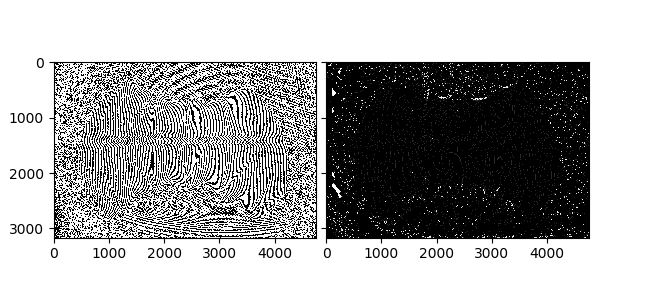

(<matplotlib.image.AxesImage at 0x23e044ccbe0>,
 <matplotlib.image.AxesImage at 0x23e044cce80>)

In [18]:
fig = plt.figure(figsize=(6.69,3))
ft.plot_compare(fig, thresholded, thinned*1 + errors*5)

In [19]:
ft.save_file_alpha(fn+' errors', errors, colors=[255, 0, 0])